In [4]:
import pandas as pd
from spotify import *

In [6]:
del_water_tracks = get_artistTracks('Del Water Gap')

In [111]:
nick_tracks = get_artistTracks('Nick Cianci')

## track features 

In [7]:
del_water_tracks[:5]

[{'name': "Don't Say Nothing - live in Fresno",
  'id': '4iCAH9P6e4ilKhc60qcRJv',
  'artists': ['Del Water Gap']},
 {'name': 'Theory of Emotion - live in Fresno',
  'id': '1jdcKxb3I3rzQUYZyekCgr',
  'artists': ['Del Water Gap']},
 {'name': 'Chastain - live in Fresno',
  'id': '519l7sJ9H0vshmI2X4rgQL',
  'artists': ['Del Water Gap']},
 {'name': 'To Philly - live in Fresno',
  'id': '3IAcmRXOPwmDLht8UDDrYp',
  'artists': ['Del Water Gap']},
 {'name': 'Laid Down My Arms - live in Fresno',
  'id': '5sYmFFLcruE6zBaO55Cl7d',
  'artists': ['Del Water Gap']}]

In [105]:
def tracks_toDF(tracks):
    records = []
    for track in tracks:
        audio_features = sp.audio_features(track['id'])[0]
        audio_features['artists'] = track['artists']
        audio_features['name'] = track['name']
        records.append(audio_features)

    df = pd.DataFrame.from_records(records)

    df['artists'] = df.apply(lambda x : "".join([artist+', ' for artist in x['artists']]).strip(', '),axis=1)

    trs = sp.tracks(df['id'].to_list())

    df['popularity'] = df['id'].map({x['id']:x['popularity'] for x in trs['tracks']})

    df['release_date'] = df['id'].map({x['id']:x['album']['release_date'] for x in trs['tracks']})
    return df
df = tracks_toDF(del_water_tracks)

In [106]:
df[df['name']=='Theory of Emotion']

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,artists,name,popularity,release_date
12,0.563,0.437,4,-6.312,1,0.0272,0.0749,0.0,0.301,0.246,...,2xA8KeiUMjuMs2HF0rlvYj,spotify:track:2xA8KeiUMjuMs2HF0rlvYj,https://api.spotify.com/v1/tracks/2xA8KeiUMjuM...,https://api.spotify.com/v1/audio-analysis/2xA8...,312440,4,Del Water Gap,Theory of Emotion,11,2019-04-12
23,0.563,0.437,4,-6.312,1,0.0272,0.0749,0.0,0.301,0.246,...,4VPXPOfhKDhtsYhSC27NLn,spotify:track:4VPXPOfhKDhtsYhSC27NLn,https://api.spotify.com/v1/tracks/4VPXPOfhKDht...,https://api.spotify.com/v1/audio-analysis/4VPX...,312440,4,Del Water Gap,Theory of Emotion,23,2019-04-09


In [107]:
df.loc[18,'name']='Theory of Emotion'

In [108]:
data = df.groupby('name').mean()

### Visualize 

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(20,18)})

In [112]:
nick_df = tracks_toDF(nick_tracks)
nick_data = nick_df.groupby('name').mean()

In [132]:
def track_scatterPlot(data,x,y,xlabel,ylabel,title):
    p1 = sns.regplot(data=data,x=x,y=y,fit_reg=False,scatter_kws={'s':400})
    for line in range(0,data.shape[0]):
        p1.text(data[x][line]+.02,data[y][line],data.index[line],
                horizontalalignment='left',size='large',color='black',weight='semibold')
    plt.xlabel(xlabel,fontdict={'size':25})
    plt.ylabel(ylabel,fontdict={'size':25})
    plt.title(title,fontdict={'size':30})
    plt.savefig('images/'+title)

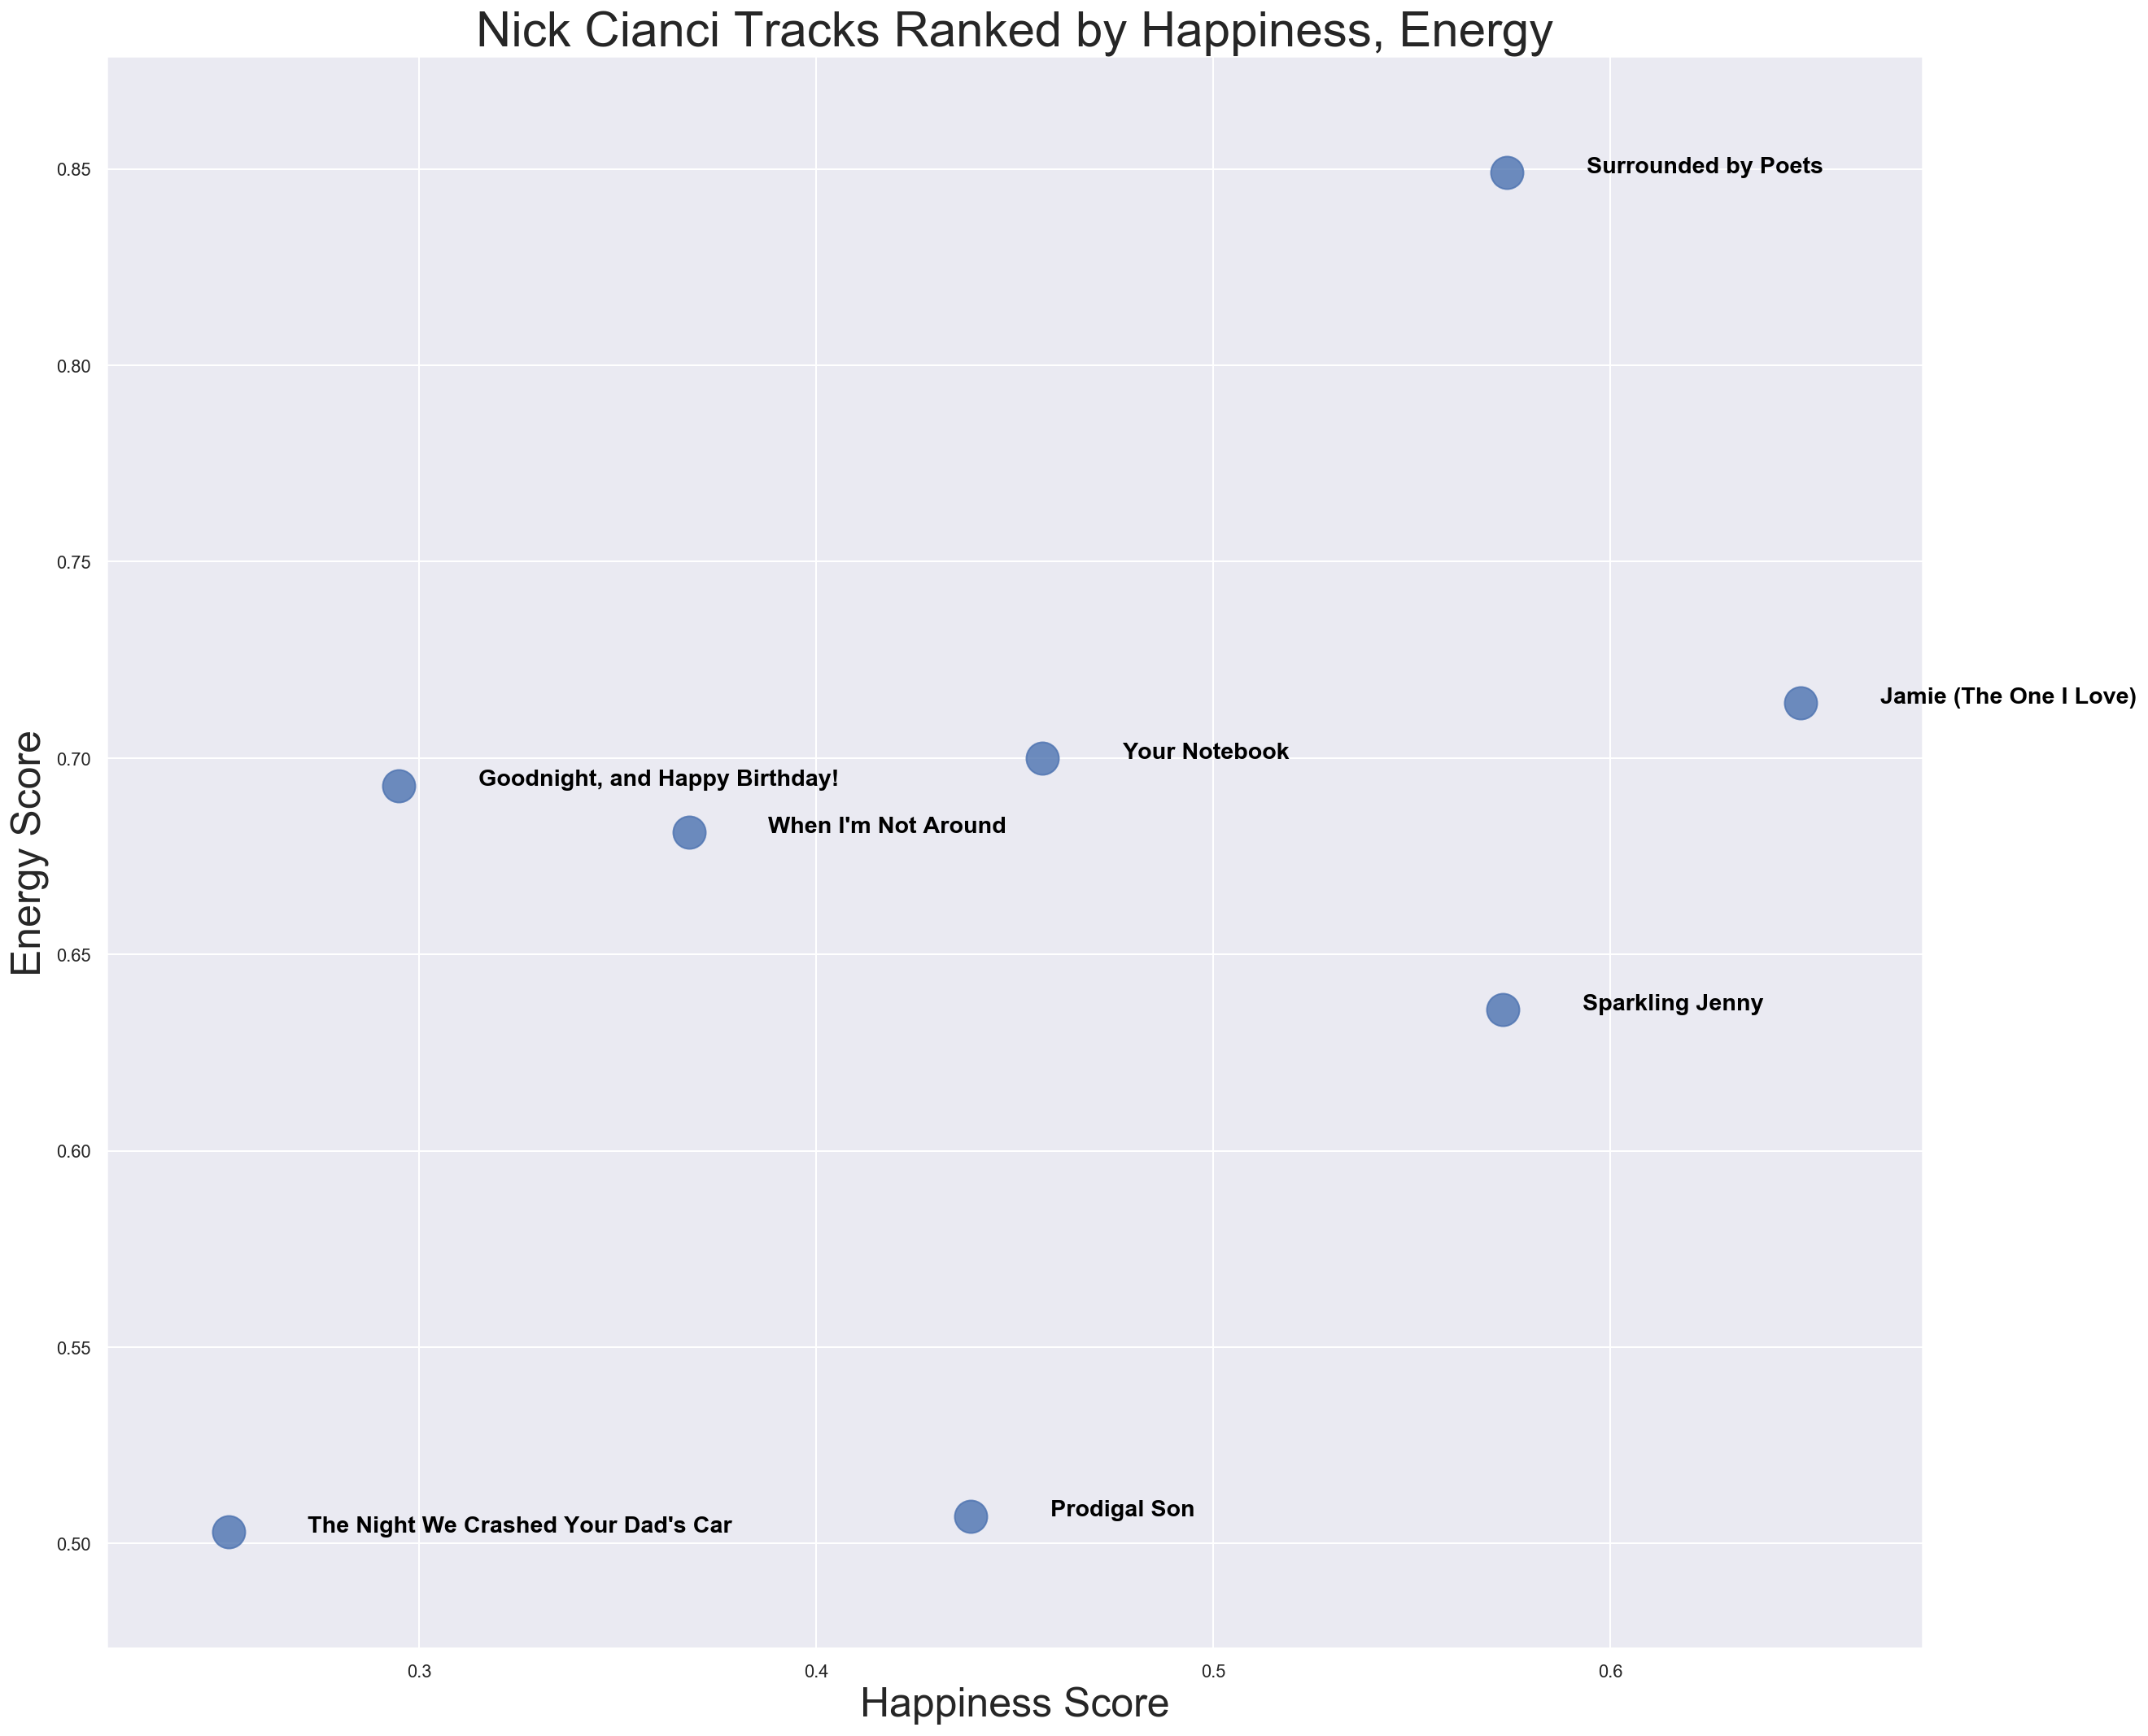

In [134]:
track_scatterPlot(nick_data,'valence','energy','Happiness Score','Energy Score','Nick Cianci Tracks Ranked by Happiness, Energy')

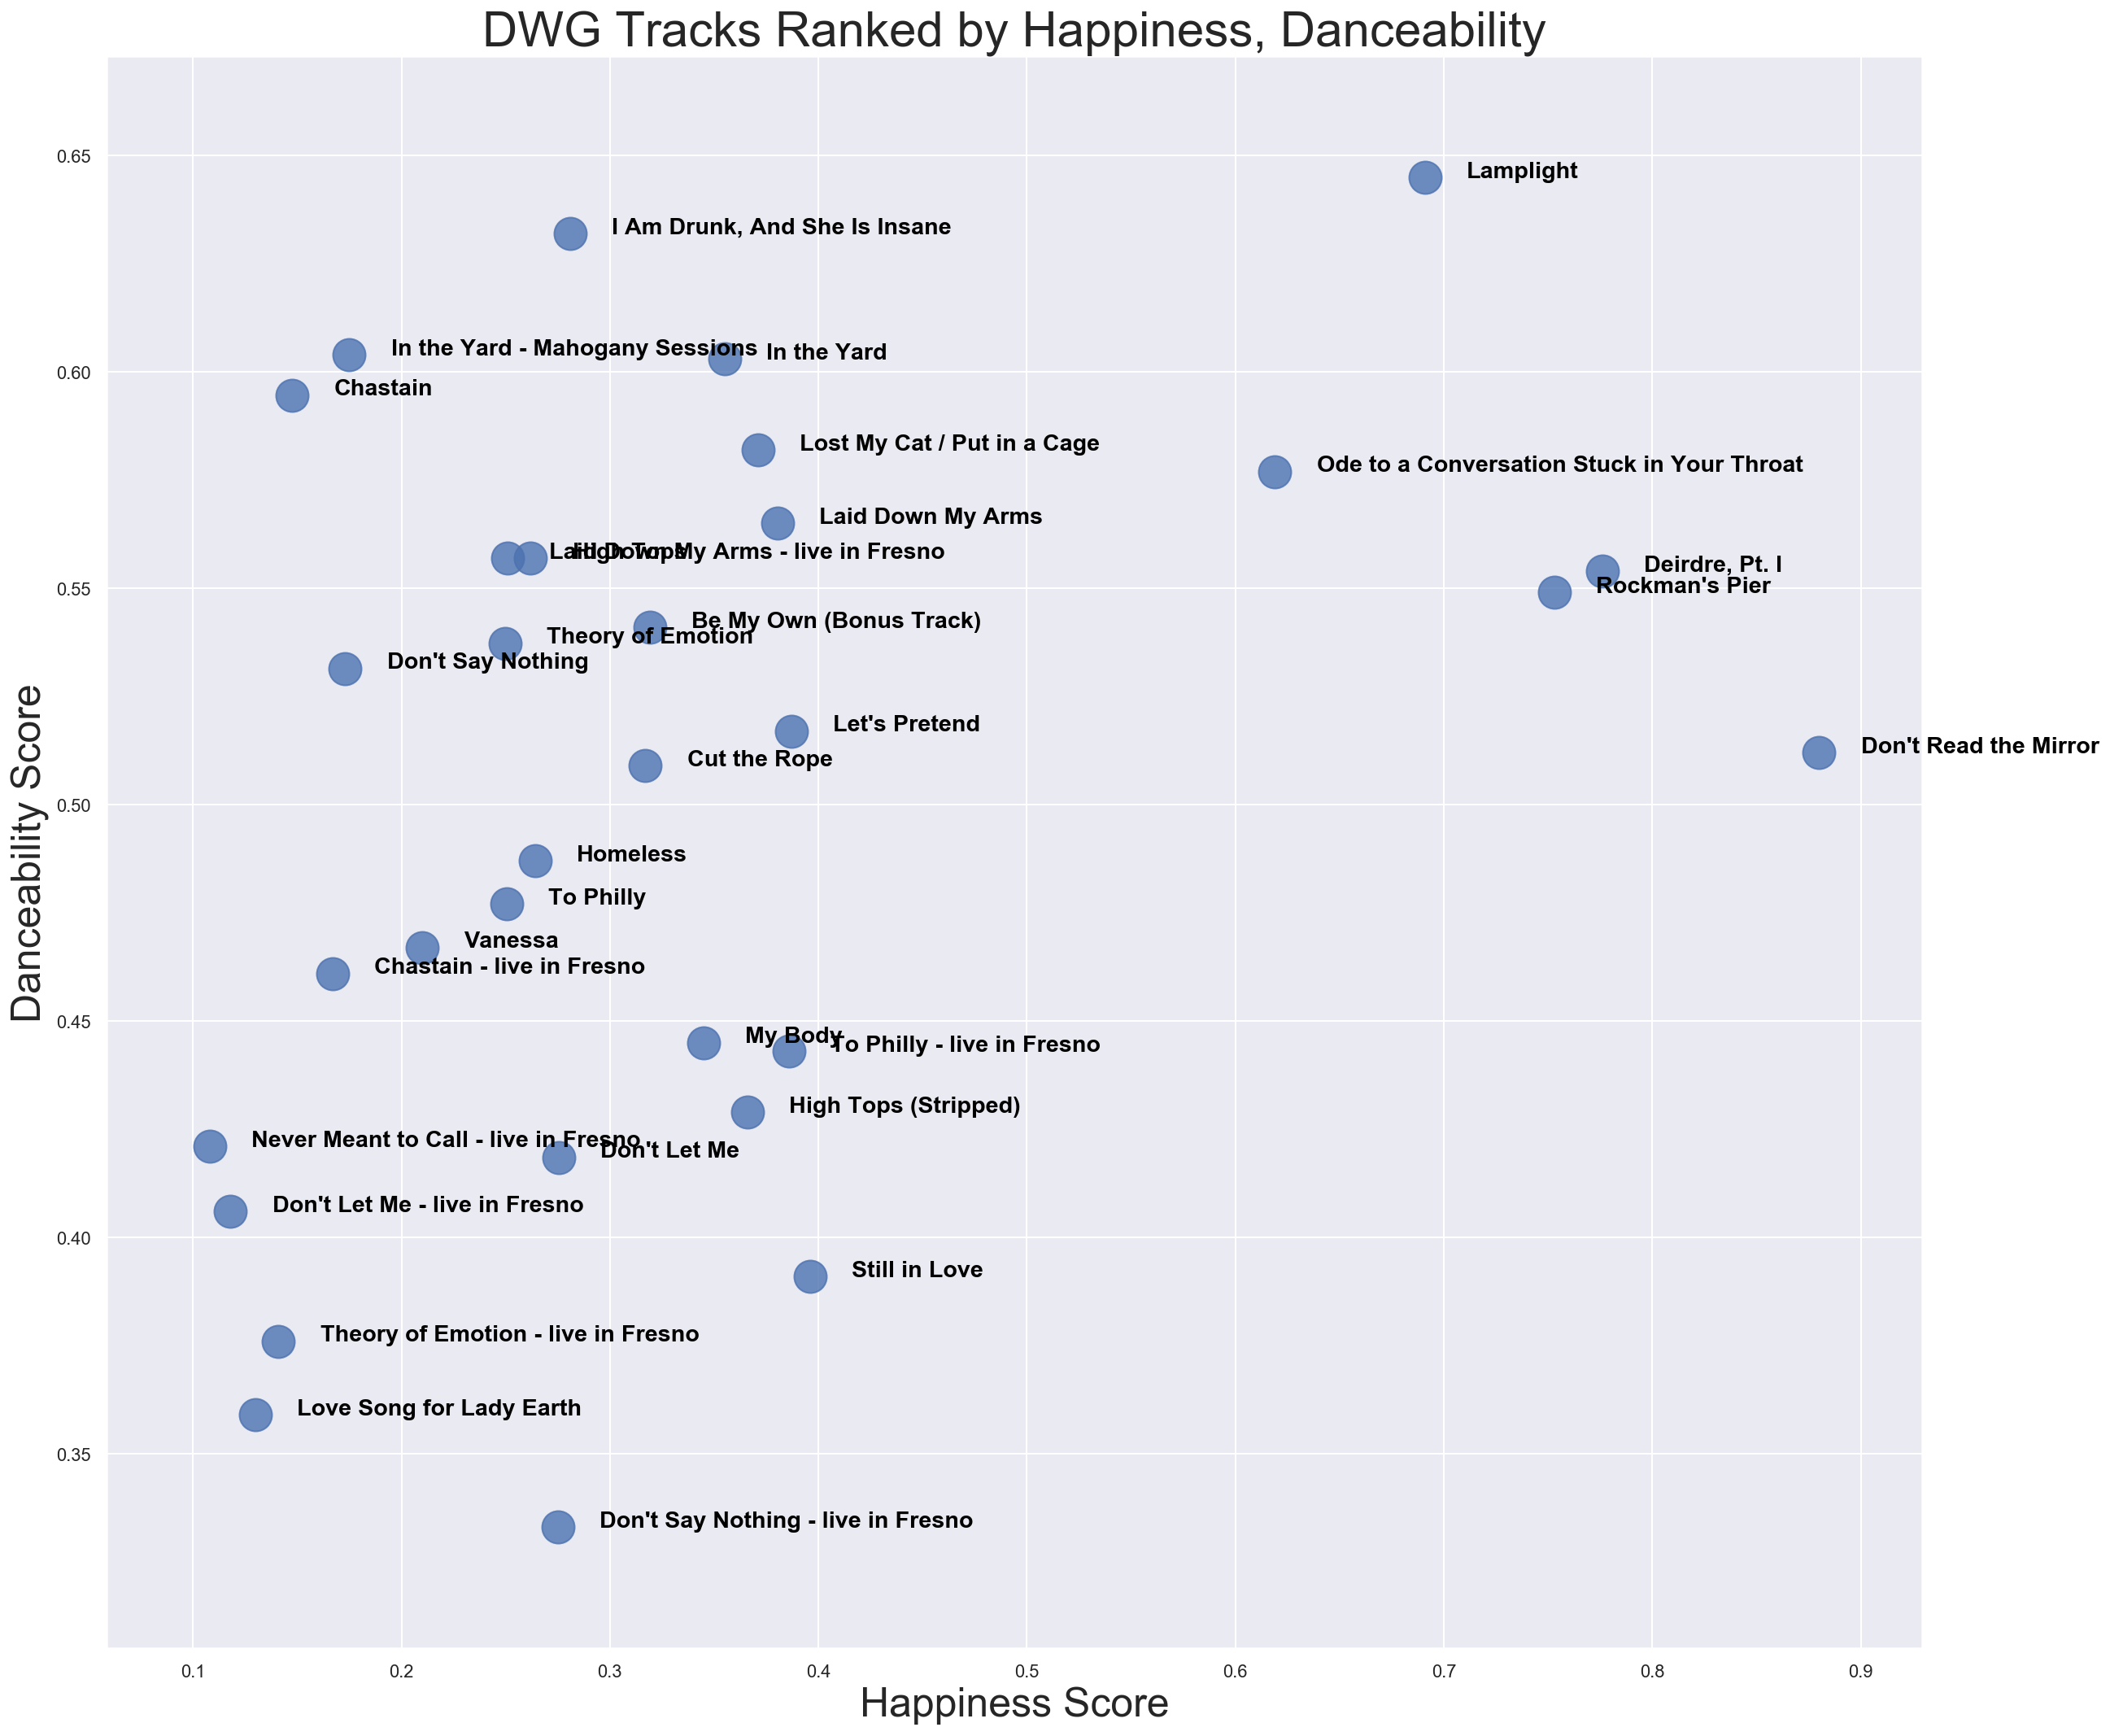

In [154]:
track_scatterPlot(data,'valence','danceability','Happiness Score','Danceability Score','DWG Tracks Ranked by Happiness, Danceability')

In [152]:
samia_tracks = get_artistTracks('Samia')
samia_df = tracks_toDF(samia_tracks)
samia_df['name']=samia_df['name'].str.title()
samia_data = samia_df[samia_df['artists']=='Samia'].groupby('name').mean()

In [153]:
samia_data

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
name,,,,,,,,,,,,,,
21,0.4825,0.5615,9.0,-7.0430,1.0,0.03700,0.02955,0.000002,0.1260,0.5620,154.5215,192124.5,4.0,23.5
Django,0.5580,0.1360,8.0,-11.7310,0.0,0.03370,0.79900,0.000000,0.1000,0.1410,80.2590,204285.0,4.0,51.0
Gotta Have You - The Wild Honey Pie Buzzsession,0.4910,0.5050,11.0,-8.7370,1.0,0.02700,0.14700,0.000030,0.0867,0.5140,79.1190,167985.0,4.0,35.0
Is There Something In The Movies?,0.5005,0.1010,7.0,-13.0085,1.0,0.04625,0.91450,0.000000,0.0889,0.1535,92.7255,210173.0,3.5,15.0
Lasting Friend,0.4560,0.7050,4.0,-3.6950,1.0,0.03990,0.07920,0.001370,0.2150,0.2470,118.4910,205645.0,4.0,20.5
Milk,0.5820,0.3860,5.0,-8.5460,1.0,0.02740,0.87600,0.000480,0.1400,0.2130,119.9510,234891.0,3.0,34.0
Never Said,0.6050,0.4050,0.0,-5.7310,1.0,0.02490,0.19400,0.000016,0.0981,0.4170,90.0230,230027.0,4.0,29.0
Ode To Artifice,0.6760,0.7460,10.0,-7.0470,1.0,0.03640,0.29700,0.000000,0.1040,0.6020,128.0030,165468.0,4.0,35.5
Paris,0.4770,0.1080,4.0,-16.4840,0.0,0.04460,0.97800,0.000754,0.1530,0.2420,118.8550,200092.0,4.0,38.5


In [25]:
with_charlie = [
    'I Am Drunk, And She Is Insane', 'Lost My Cat / Put in a Cage', 
    "Rockman's Pier", 'Still in Love', 'Lamplight', 'Cut the Rope', 
    'Vanessa', 'High Tops', 'Love Song for Lady Earth', "Let's Pretend",
    'Deirdre, Pt. I', "Don't Read the Mirror", 'Laid Down My Arms','Theory of Emotion'
]

In [26]:
not_charlie = df[~df['name'].isin(with_charlie)]['valence']

In [27]:
charlie = df[df['name'].isin(with_charlie)]['valence']

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

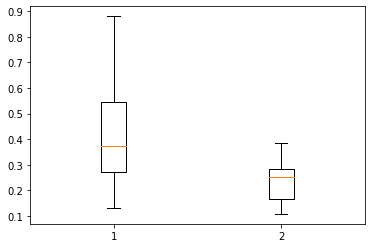

In [29]:
fig, ax = plt.subplots()
ax.boxplot([charlie,not_charlie])

plt.show()

## by playlist

In [31]:
sam_playlists = sp.user_playlists(1250134147)

In [32]:
sam_playlist_ids = [
    {'playlist_id':x['id'],'playlist_name':x['name']} for x in sam_playlists['items']]

In [33]:
sam_playlist_ids

[{'playlist_id': '0ti4xxabrASrUfndyMAM84', 'playlist_name': 'the end'},
 {'playlist_id': '4onXnKlx8zqSBFMoegjnTX',
  'playlist_name': 'wfh: pandemic edition'},
 {'playlist_id': '5pSaH0lwwMZQv4icmvLODy', 'playlist_name': 'working'},
 {'playlist_id': '5x3kN5QBau7m55CDq31jxY', 'playlist_name': 'hbd, dave'},
 {'playlist_id': '4yhHSqzDCxttvBEfMBOODi',
  'playlist_name': 'unpretentious resort wave'},
 {'playlist_id': '6jmzGHmwwueGgqw376qJku',
  'playlist_name': 'all killer no filler'},
 {'playlist_id': '2VBPgWKiFM2N5lXEFYp7sk',
  'playlist_name': 'The Wry Young Women Writing Sad, Buoyant, Beautiful Songs'}]

In [34]:
import time

In [36]:
records = []
for playlist in sam_playlist_ids:
    playlist_items = sp.playlist_tracks(playlist['playlist_id'])['items']
    track_ids = [item['track']['id'] for item in playlist_items]
    
    audio_features = [sp.audio_features(x)[0] for x in track_ids]
    for track in audio_features:
        track['playlist_name']=playlist['playlist_name']
    records.extend(audio_features)
    time.sleep(5)

In [37]:
playlist_df = pd.DataFrame.from_records(records)

In [38]:
playlist_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,playlist_name
0,0.459,0.617,8,-5.810,1,0.0353,0.000056,0.354000,0.0443,0.522,117.959,audio_features,1qoqz2LrkRl2A24OSdp6wI,spotify:track:1qoqz2LrkRl2A24OSdp6wI,https://api.spotify.com/v1/tracks/1qoqz2LrkRl2...,https://api.spotify.com/v1/audio-analysis/1qoq...,208967,4,the end
1,0.381,0.436,5,-6.731,1,0.0329,0.011800,0.000000,0.1330,0.453,183.923,audio_features,2guw9QqCoBNGlJTPQBAAHk,spotify:track:2guw9QqCoBNGlJTPQBAAHk,https://api.spotify.com/v1/tracks/2guw9QqCoBNG...,https://api.spotify.com/v1/audio-analysis/2guw...,149077,3,the end
2,0.468,0.635,8,-7.079,1,0.0273,0.000202,0.446000,0.1100,0.249,103.946,audio_features,6OHVsfC65IdO9MM8oQPthL,spotify:track:6OHVsfC65IdO9MM8oQPthL,https://api.spotify.com/v1/tracks/6OHVsfC65IdO...,https://api.spotify.com/v1/audio-analysis/6OHV...,159940,4,the end
3,0.262,0.651,9,-8.413,1,0.0322,0.000070,0.020200,0.0883,0.175,100.463,audio_features,2Lk6WptvmyH5SN73Pi4vZx,spotify:track:2Lk6WptvmyH5SN73Pi4vZx,https://api.spotify.com/v1/tracks/2Lk6WptvmyH5...,https://api.spotify.com/v1/audio-analysis/2Lk6...,237823,4,the end
4,0.377,0.499,9,-7.228,1,0.0323,0.002350,0.007680,0.1180,0.412,173.595,audio_features,52bYAaDo17L4JNdkBZ1rIw,spotify:track:52bYAaDo17L4JNdkBZ1rIw,https://api.spotify.com/v1/tracks/52bYAaDo17L4...,https://api.spotify.com/v1/audio-analysis/52bY...,206672,4,the end
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.181,0.653,5,-5.102,1,0.0380,0.366000,0.000085,0.1600,0.371,204.164,audio_features,3Nb8Fqfi1N01eAASK9jduB,spotify:track:3Nb8Fqfi1N01eAASK9jduB,https://api.spotify.com/v1/tracks/3Nb8Fqfi1N01...,https://api.spotify.com/v1/audio-analysis/3Nb8...,161600,4,"The Wry Young Women Writing Sad, Buoyant, Beau..."
233,0.459,0.824,5,-5.296,1,0.0399,0.007650,0.003540,0.1670,0.355,126.352,audio_features,5Ap9hgpKbDugMg7dQmtKgm,spotify:track:5Ap9hgpKbDugMg7dQmtKgm,https://api.spotify.com/v1/tracks/5Ap9hgpKbDug...,https://api.spotify.com/v1/audio-analysis/5Ap9...,180800,4,"The Wry Young Women Writing Sad, Buoyant, Beau..."
234,0.538,0.275,2,-8.015,1,0.0278,0.661000,0.000033,0.1450,0.186,97.548,audio_features,64sDUuHnNZgo5cnhVq9lIg,spotify:track:64sDUuHnNZgo5cnhVq9lIg,https://api.spotify.com/v1/tracks/64sDUuHnNZgo...,https://api.spotify.com/v1/audio-analysis/64sD...,152267,4,"The Wry Young Women Writing Sad, Buoyant, Beau..."
235,0.279,0.777,6,-3.922,1,0.0462,0.183000,0.761000,0.0874,0.605,118.977,audio_features,3kLsqsxZ9DDwmllHisvK92,spotify:track:3kLsqsxZ9DDwmllHisvK92,https://api.spotify.com/v1/tracks/3kLsqsxZ9DDw...,https://api.spotify.com/v1/audio-analysis/3kLs...,218400,4,"The Wry Young Women Writing Sad, Buoyant, Beau..."


In [39]:
def audioFeatures_byArtist(name=None,artist_id=None,track_ids=None,playlist=None):
    pass